In [28]:
# Import packages
from tools.to_read import *
from tools.to_plot import *
from tools.to_do import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import os
# Set up
root='/home/jacoponudo/Documents/Size_effects/'
platforms = ['gab', 'reddit', 'twitter', 'usenet', 'voat','facebook']

## Entrance in the conversation

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from tqdm import tqdm 

# Assuming `platforms`, `root`, `palette`, and `calculate_lifetime_percentile` are already defined

# Loop through each platform
for idx, platform in tqdm(enumerate(platforms)):
    if not os.path.exists(csv_filename):
        data = pd.read_parquet(root + 'DATA/' + platform + '/' + platform + '_raw_data.parquet', columns=columns_to_read[platform])
        data.columns = standard_columns
        data['timestamp'] = pd.to_datetime(data['timestamp'])
        df_sorted = data.sort_values(by=['timestamp'])

        # Get the first comment for each post_id and user_id
        first_comments = df_sorted.groupby(['post_id', 'user_id']).first().reset_index()

        # Get the first comment for each post_id (first for the post)
        first_post_comments = df_sorted.groupby('post_id').first().reset_index()

        # Merge the two DataFrames to get the time difference
        df = pd.merge(first_comments, first_post_comments, on='post_id', suffixes=('', '_post'))

        # Calculate the time difference in hours
        df['time_difference_seconds'] = (df['timestamp'] - df['timestamp_post']).dt.total_seconds() / 3600

        # Add the column with the number of unique users per post_id
        df['num_users_per_post'] = df.groupby('post_id')['user_id'].transform('nunique')
        df = df.dropna(subset=['time_difference_seconds', 'num_users_per_post'])
        df['log_unique_users'] = df['num_users_per_post'] 
        df['log_duration'] = df['time_difference_seconds'] + 1
        bin_edges = [1, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192] + [np.inf]  # Define bins for user counts
        df['user_bin'] = pd.cut(df['log_unique_users'], bins=bin_edges)
        bin_counts = df['user_bin'].value_counts()
        valid_bins = bin_counts[bin_counts >= 200].index
        filtered_df = df[df['user_bin'].isin(valid_bins)]

        # Calculate statistics for lineplot
        stats = filtered_df.groupby('user_bin')['log_duration'].agg(
            median='median',
            q1=lambda x: x.quantile(0.3),
            q3=lambda x: x.quantile(0.7),
            p80=lambda x: x.quantile(0.8),
            p20=lambda x: x.quantile(0.2)
        ).reset_index()

        # Convert user_bin to string for plotting
        stats['user_bin_str'] = stats['user_bin'].astype(str)

        # Check if CSV file exists before saving
        csv_filename = root + f'PAPER/output/1_section/3_entrance_in_conversation_{platform}.csv'
        stats.to_csv(csv_filename, index=False)
    
    # Read the CSV file
    csv_filename = root + f'PAPER/output/1_section/3_entrance_in_conversation_{platform}.csv'
    stats = pd.read_csv(csv_filename)
    stats.loc[stats['median'] > 1000, stats.columns != 'user_bin'] = np.nan
    
    # Create a new figure for each plot
    plt.figure(figsize=(8, 6))

    # Plotting with Seaborn
    sns.lineplot(data=stats, x='user_bin_str', y='median', marker='o', label='Median', color=palette[platform])

    # Add shaded area for IQR (Q1-Q3)
    plt.fill_between(
        x=range(len(stats)),
        y1=stats['q1'],
        y2=stats['q3'],
        alpha=0.3,
        color=palette[platform],
        label='IQR (30th-70th percentile)'
    )
    plt.fill_between(
        x=range(len(stats)),
        y1=stats['p80'],
        y2=stats['p20'],
        alpha=0.1,
        color=palette[platform],
        label='IQR (20th-80th percentile)'
    )

    # Customizing plot
    plt.yscale('log')
    plt.ylim(0, 1000)
    plt.title(f'{platform.capitalize()}')

    plt.xlabel('Number of users (logarithmic)')
    bin_intervals = filtered_df['user_bin'].cat.categories  # Get actual categories for filtered data
    x_labels = [str(int(interval.left)) for interval in bin_intervals]  # Display the left edge of each bin
    plt.xticks(range(len(bin_intervals)), x_labels, rotation=45)

    plt.ylabel('Entrance (hours)')

    # Save the individual plot as PNG
    plot_filename = root + f'PAPER/output/1_section/3_entrance_in_conversation_{platform}.png'
    plt.tight_layout()
    plt.savefig(plot_filename)
    plt.close()  # Close the plot to save memory




0it [00:00, ?it/s]/tmp/ipykernel_67004/2147019044.py:88: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 1000)
1it [00:00,  3.95it/s]/tmp/ipykernel_67004/2147019044.py:88: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 1000)
2it [00:00,  3.01it/s]/tmp/ipykernel_67004/2147019044.py:88: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 1000)
3it [00:00,  3.41it/s]/tmp/ipykernel_67004/2147019044.py:88: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 1000)
4it [00:01,  3.61it/s]/tmp/ipykernel_67004/2147019044.py:88: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 1000)
5it [00:01,  3.79it/s]/tmp/ipykernel_67004/2147019044.py:88: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 1000)
6it [00:01,  3

In [43]:
platform='voat'

csv_filename = root + f'PAPER/output/1_section/3_entrance_in_conversation_{platform}.csv'
stats=pd.read_csv(csv_filename)

In [46]:
stats.loc[stats['median'] > 1000, stats.columns != 'user_bin'] = np.nan
stats

,user_bin,median,q1,q3,p80,p20,user_bin_str
0,"(1.0, 8.0]",1.733333,1.081389,3.114722,4.472778,1.000000,"(1.0, 8.0]"
1,"(8.0, 16.0]",2.876389,1.798333,4.685278,6.458056,1.376667,"(8.0, 16.0]"
2,"(16.0, 32.0]",3.420278,2.229444,5.437500,7.421556,1.739444,"(16.0, 32.0]"
3,"(32.0, 64.0]",3.688611,2.440278,5.874444,8.036667,1.940556,"(32.0, 64.0]"
4,"(64.0, 128.0]",3.815833,2.529167,6.146306,8.367722,2.025833,"(64.0, 128.0]"
5,"(128.0, 256.0]",3.561944,2.318889,5.734833,7.995111,1.892500,"(128.0, 256.0]"
6,"(256.0, 512.0]",NaN,NaN,NaN,NaN,NaN,"(256.0, 512.0]"
7,"(512.0, 1024.0]",NaN,NaN,NaN,NaN,NaN,NaN
8,"(1024.0, 2048.0]",NaN,NaN,NaN,NaN,NaN,"(1024.0, 2048.0]"
9,"(2048.0, 4096.0]",NaN,NaN,NaN,NaN,NaN,"(2048.0, 4096.0]"


## Lifetime vs number of users in a conversation


/tmp/ipykernel_49430/2293710886.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats = filtered_df.groupby('user_bin')['log_duration'].agg(
/tmp/ipykernel_49430/2293710886.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats = filtered_df.groupby('user_bin')['log_duration'].agg(
/tmp/ipykernel_49430/2293710886.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats = filtered_df.groupby('user_bin')['log_du

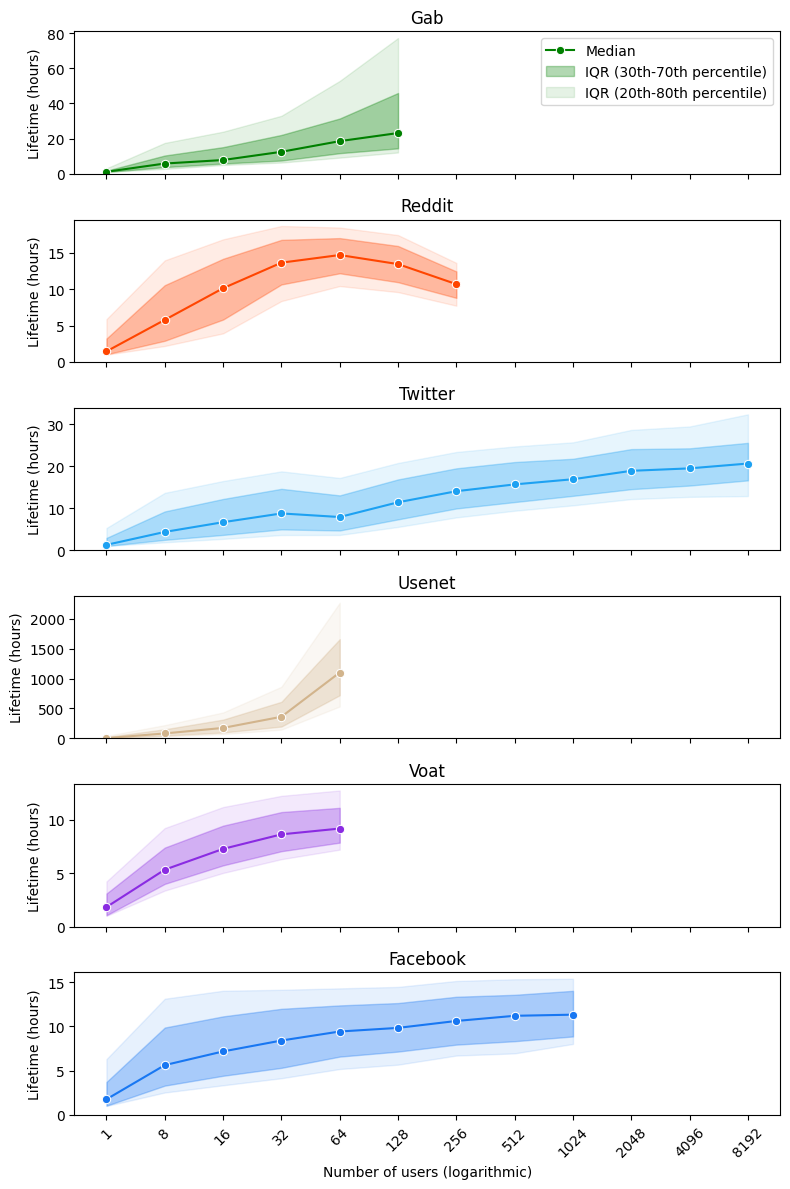

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

# Assuming `platforms`, `root`, `palette`, and `calculate_lifetime_percentile` are already defined
fig, axes = plt.subplots(len(platforms), 1, figsize=(8, 2 * len(platforms)), sharex=True)
for idx, platform in enumerate(platforms):
    output_path = root + 'PAPER/output/1_section/2_lifetime_thread_{}.csv'.format(platform)
    if not os.path.exists(output_path):
        calculate_lifetime_percentile(data, 80, output_path)

    # Data preparation
    df = pd.read_csv(output_path, dtype={'post_id': str})
    df = df.dropna(subset=['duration_percentile', 'unique_user_count'])
    df['log_unique_users'] = df['unique_user_count'] + 1
    df['log_duration'] = df['duration_percentile'] + 1
    bin_edges = [1, 8, 16, 32, 64, 128, 256, 512, 1024, 2048,4096, 8192]+ [np.inf]#[2**x for x in range(12)] + [np.inf]
    df['user_bin'] = pd.cut(df['log_unique_users'], bins=bin_edges)
    bin_counts = df['user_bin'].value_counts()
    valid_bins = bin_counts[bin_counts >= 100].index
    filtered_df = df[df['user_bin'].isin(valid_bins)]

    # Calculate statistics for lineplot
    stats = filtered_df.groupby('user_bin')['log_duration'].agg(
        median='median',
        q1=lambda x: x.quantile(0.3),
        q3=lambda x: x.quantile(0.7),
        p80=lambda x: x.quantile(0.8),
        p20=lambda x: x.quantile(0.2)
    ).reset_index()

    # Convert user_bin to string for plotting
    stats['user_bin_str'] = stats['user_bin'].astype(str)

    # Plotting with Seaborn
    ax = axes[idx]
    sns.lineplot(data=stats, x='user_bin_str', y='median', marker='o', label='Median', color=palette[platform], ax=ax)

    # Add shaded area for IQR (Q1-Q3)
    ax.fill_between(
        x=range(len(stats)),
        y1=stats['q1'],
        y2=stats['q3'],
        alpha=0.3,
        color=palette[platform],
        label='IQR (30th-70th percentile)'
    )
    ax.fill_between(
        x=range(len(stats)),
        y1=stats['p80'],
        y2=stats['p20'],
        alpha=0.1,
        color=palette[platform],
        label='IQR (20th-80th percentile)'
    )

    # Customizing plot
    #ax.set_yscale('log')
    ax.set_ylim(bottom=0)
    ax.set_title(f'{platform.capitalize()}')
    
    # Only add legend to the first plot
    if idx == 0:
        ax.legend()
    else:
        ax.legend().set_visible(False)

    if idx == len(platforms) - 1:
        ax.set_xlabel('Number of users (logarithmic)')
        # Adjust x-axis labels for the last plot
        bin_intervals = filtered_df['user_bin'].cat.categories  # Get actual categories for filtered data
        x_labels = [str(int(interval.left)) for interval in bin_intervals]  # Display the left edge of each bin
        ax.set_xticks(range(len(bin_intervals)))  # Ensure ticks match the number of bins
        ax.set_xticklabels(x_labels, rotation=45)
    else:
        ax.set_xlabel('')
    ax.set_ylabel('Lifetime (hours)')

plt.tight_layout()
plt.savefig(root + 'PAPER/output/1_section/combined_lifetime_thread_plots.png')
plt.show()


In [11]:
[2**x for x in range(15)]

[1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384]

In [4]:
x_labels

['1.0',
 '8.0',
 '16.0',
 '32.0',
 '64.0',
 '128.0',
 '256.0',
 '512.0',
 '1024.0',
 '2048.0']

In [11]:
bin_edges

[1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, inf]

<Figure size 1000x600 with 0 Axes>

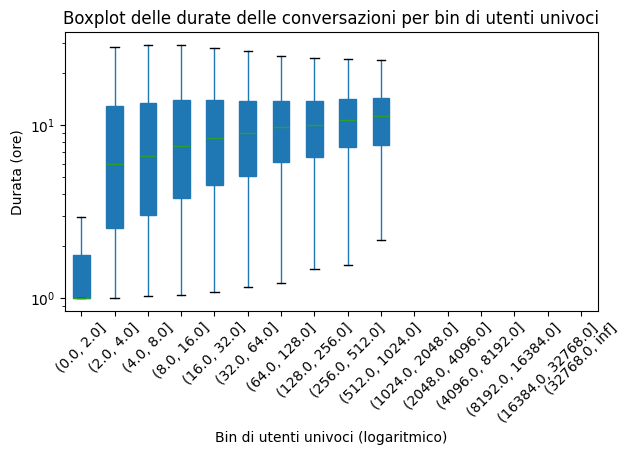

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Aggiungiamo 1 agli utenti per evitare errori nel logaritmo con il valore 0
final_df['log_unique_users'] =(final_df['unique_users'])
final_df['log_duration'] = (final_df['duration'])+1

# Definisci i bin basati su potenze di 2
bin_edges = [0, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768, np.inf]


# Crea i bin con pd.cut
final_df['user_bin'] = pd.cut(final_df['log_unique_users'], bins=bin_edges)

# Conta il numero di osservazioni in ogni bin
bin_counts = final_df['user_bin'].value_counts()

# Filtra i bin con meno di 100 osservazioni
valid_bins = bin_counts[bin_counts >= 300].index
filtered_df = final_df[final_df['user_bin'].isin(valid_bins)]

# Plotting dei boxplot per le durate per ogni bin valido
plt.figure(figsize=(10, 6))
filtered_df.boxplot(column='log_duration', by='user_bin', grid=False, patch_artist=True, showfliers=False)
plt.title('Boxplot delle durate delle conversazioni per bin di utenti univoci')
plt.suptitle('')  # Rimuove il titolo predefinito
plt.xlabel('Bin di utenti univoci (logaritmico)')
plt.ylabel('Durata (ore)')
plt.xticks(rotation=45)

plt.yscale('log')
plt.tight_layout()
plt.show()


## Evaporazione della community e del dialogo su reddit

In [ ]:
# Importare librerie necessarie
import pandas as pd

# Filtrare il DataFrame per subreddit
filtered_data = data[data['subreddit_code'] == 't5_mouw']

# Assicurati che la colonna 'created_time' sia in formato datetime
filtered_data['created_time'] = pd.to_datetime(filtered_data['date'])

# Estrai l'anno e il mese dalla colonna 'created_time'
filtered_data['year_month'] = filtered_data['created_time'].dt.to_period('d')

# Calcola il numero univoco di utenti per ogni mese e anno
unique_users_per_month = filtered_data.groupby('year_month')['user_id'].nunique().reset_index()

# Rinomina le colonne per chiarezza
unique_users_per_month.columns = ['Month_Year', 'Unique_Users']

# Visualizza il risultato
print(unique_users_per_month)



filtered_data = data[data['subreddit_code'] == 't5_3jwf7']

# Assicurati che la colonna 'created_time' sia in formato datetime
filtered_data['created_time'] = pd.to_datetime(filtered_data['date'])

# Estrai l'anno e il mese dalla colonna 'created_time'
filtered_data['year_month'] = filtered_data['created_time'].dt.to_period('M')

# Raggruppa per 'user_id' e 'post_id', e calcola il numero di commenti e la data del primo commento
result = filtered_data.groupby(['user_id', 'post_id']).agg(
    num_comments=('date', 'size'),
    first_comment_date=('date', 'min'),
    year_month=('year_month', 'first')  # L'anno e mese del primo commento
).reset_index()

result['alpha']=result['num_comments']==1
result.groupby('year_month')['alpha'].mean().reset_index()

unique_users_per_month[['Month_Year','Unique_Users']]

      Month_Year  Unique_Users
0     2018-01-01            31
1     2018-01-02            98
2     2018-01-03           405
3     2018-01-04           385
4     2018-01-05           249
...          ...           ...
1455  2022-03-30             1
1456  2022-12-08           106
1457  2022-12-09           456
1458  2022-12-10             3
1459  2022-12-11             2

[1460 rows x 2 columns]


/tmp/ipykernel_15746/4229651526.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['created_time'] = pd.to_datetime(filtered_data['date'])
/tmp/ipykernel_15746/4229651526.py:11: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  filtered_data['year_month'] = filtered_data['created_time'].dt.to_period('d')
/tmp/ipykernel_15746/4229651526.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['year_month'] = filtered_data['created_time'].dt

,Month_Year,Unique_Users
0,2018-01-01,31
1,2018-01-02,98
2,2018-01-03,405
3,2018-01-04,385
4,2018-01-05,249
...,...,...
1455,2022-03-30,1
1456,2022-12-08,106
1457,2022-12-09,456
1458,2022-12-10,3


In [35]:

filtered_data = data[data['subreddit_code'] == 't5_3jwf7']

# Assicurati che la colonna 'created_time' sia in formato datetime
filtered_data['created_time'] = pd.to_datetime(filtered_data['date'])

# Estrai l'anno e il mese dalla colonna 'created_time'
filtered_data['year_month'] = filtered_data['created_time'].dt.to_period('d')

# Raggruppa per 'user_id' e 'post_id', e calcola il numero di commenti e la data del primo commento
result = filtered_data.groupby(['user_id', 'post_id']).agg(
    num_comments=('date', 'size'),
    first_comment_date=('date', 'min'),
    year_month=('year_month', 'first')  # L'anno e mese del primo commento
).reset_index()

result['alpha']=result['num_comments']==1
result.groupby('year_month')['alpha'].mean().reset_index()

unique_users_per_month[['Month_Year','Unique_Users']]

/tmp/ipykernel_15746/2554222395.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['created_time'] = pd.to_datetime(filtered_data['date'])
/tmp/ipykernel_15746/2554222395.py:7: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  filtered_data['year_month'] = filtered_data['created_time'].dt.to_period('d')
/tmp/ipykernel_15746/2554222395.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['year_month'] = filtered_data['created_time'].dt.t

,Month_Year,Unique_Users
0,2018-01-01,31
1,2018-01-02,98
2,2018-01-03,405
3,2018-01-04,385
4,2018-01-05,249
...,...,...
1455,2022-03-30,1
1456,2022-12-08,106
1457,2022-12-09,456
1458,2022-12-10,3


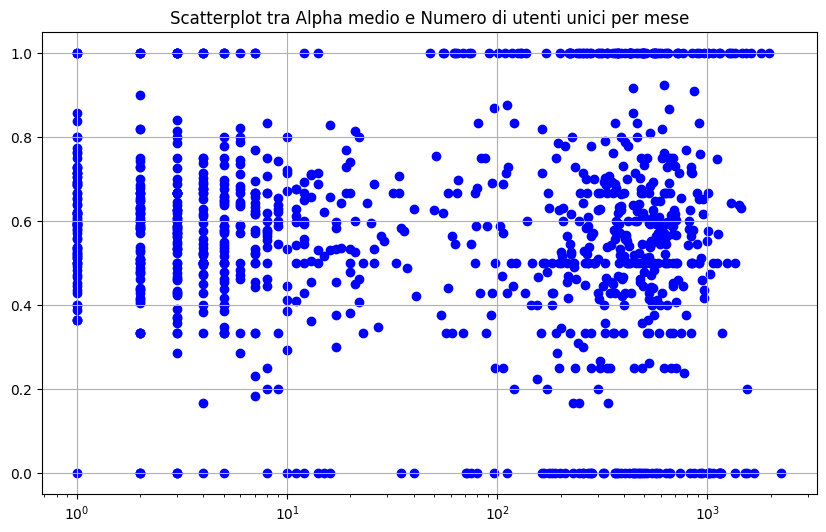

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

# Supponiamo che tu abbia già calcolato 'result' e 'unique_users_per_month'
# risultato dal primo DataFrame con 'alpha' medio per ogni 'year_month'
alpha_per_month = result.groupby('year_month')['alpha'].mean().reset_index()

# 'unique_users_per_month' contiene 'Month_Year' e 'Unique_Users'

# Esegui il merge sui DataFrame utilizzando le colonne corrispondenti
merged_data = pd.merge(alpha_per_month, unique_users_per_month, left_on='year_month', right_on='Month_Year')

# Crea lo scatterplot
plt.figure(figsize=(10, 6))
plt.scatter(merged_data['Unique_Users'],merged_data['alpha'],  color='blue')
plt.title('Scatterplot tra Alpha medio e Numero di utenti unici per mese')
plt.xscale('log')
plt.grid(True)
plt.show()
